In [156]:
from scipy.fft import rfft, irfft, fft, ifft
import numpy as np
import matplotlib.pylab as plt

from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

from sklearn.metrics import log_loss, f1_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import random

from alibi.explainers import KernelShap
import shap
shap.initjs()

from shap import Explainer
import shap.plots

from growingspheres.counterfactuals import CounterfactualExplanation
from growingspheres.growingspheres import GrowingSpheres

### Explainability of time-series on ECG200 using Fourier Transform

In this notebook I would try to explore and reproduce results from the paper [Post Hoc Explainability for Time Series Classification: Toward a signal processing perspective](https://ieeexplore.ieee.org/document/9810094). For the dataset I have chosen [ECG200](http://timeseriesclassification.com/description.php?Dataset=ECG200).

In [205]:
def load_dataset(path):
    data = np.loadtxt(path)
    y = data[:, 0]
    data = data[:, 1:]
    return data, y

def show_sample_stats(data, y):
    tags, i = np.unique(y, return_counts=True)
    plt.pie(i, labels=tags)
    plt.show()

def process_series(data, n = None):
    yf = rfft(data, n)
    return pd.DataFrame(yf)


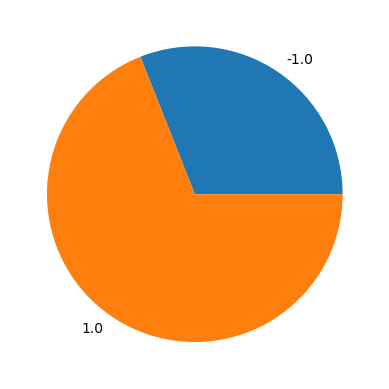

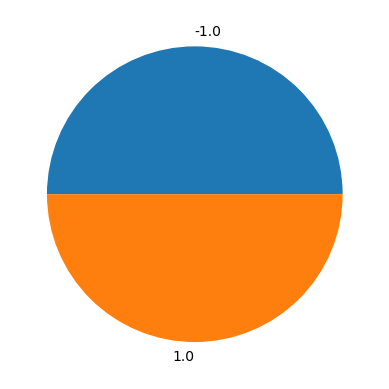

In [206]:
data, y = load_dataset("dataset_ECG200/ECG200_TRAIN.txt")

show_sample_stats(data, y)

# balance the data set using random samples from the original data
data = np.append(data, random.choices(list(data[y == -1]), k=38), axis=0)
y = np.append(y, -np.ones(38))

show_sample_stats(data, y)



In [209]:
from fft_random_forest import FFTRandomForest
from sklearn.model_selection import GridSearchCV

df = process_series(data)

clf = RandomForestClassifier()
clf.fit(np.abs(df), y)

gs_clf = GridSearchCV(estimator=FFTRandomForest(), n_jobs=4, param_grid={"n": list(range(10, 100))}, scoring='accuracy', cv=5)
gs_clf.fit(data, y)
gs_clf.best_params_

{'n': 73}

### Trying exponential smoothing to improve predictions

I tried smooth out the ECG, but the results were actually worse.

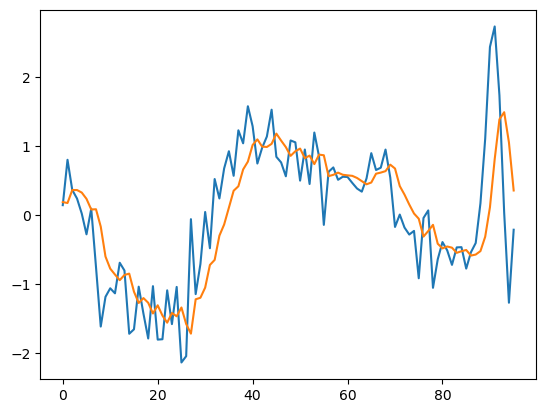

In [126]:
from statsmodels.tsa.api import SimpleExpSmoothing

fit1 = SimpleExpSmoothing(data[1]).fit(smoothing_level=0.3, optimized=True)

plt.plot(data[1])
plt.plot(fit1.fittedvalues)

### Fiting the state of the art model

I am going to compare KNN model with the classification using fourier analysis.

In [94]:
model = KNeighborsTimeSeriesClassifier(n_neighbors=3)
model.fit(data, y)
model.classes_

array([-1.,  1.])

In [95]:
test_data, y_true = load_dataset("dataset_ECG200/ECG200_TEST.txt")

df = process_series(test_data)
df.loc[0]

0     4.100000e-08
1     3.285888e+01
2     4.194352e+01
3     2.476802e+01
4     8.588162e+00
5     1.353545e+01
6     3.299199e+00
7     4.471060e+00
8     8.208414e+00
9     8.941439e+00
10    7.808020e+00
11    9.915545e+00
12    1.059248e+01
13    9.269846e+00
14    7.581567e+00
15    7.556146e+00
16    6.459763e+00
17    4.161297e+00
18    4.925642e+00
19    2.651886e+00
20    3.370941e+00
21    3.565277e+00
22    3.310432e+00
23    3.483295e+00
24    1.037791e+00
25    3.346765e+00
26    2.020248e+00
27    2.604579e+00
28    2.274890e+00
29    1.929426e+00
30    1.407486e+00
31    1.016641e+00
32    2.362353e+00
33    1.147741e+00
34    1.857209e+00
35    1.582337e+00
36    7.975839e-01
37    7.601898e-01
38    2.890961e+00
39    8.669598e-01
40    7.993537e-01
41    5.507296e-01
42    5.163266e-01
43    1.248302e+00
44    1.004239e+00
45    7.495197e-01
46    5.616745e-01
47    1.776145e-01
48    8.044095e-02
Name: 0, dtype: float32

In [96]:
y_pred_proba = model.predict_proba(test_data)
y_pred = model.predict(test_data)


In [97]:

y_pred_fft = clf.predict(df)
y_pred_fft_proba = clf.predict_proba(df)

y_pred_gs_fft = gs_clf.predict(test_data)
y_pred_gs_fft_proba = gs_clf.predict_proba(test_data)

In [98]:
# KNN model
print(log_loss(y_true, y_pred_proba))
print(accuracy_score(y_true, y_pred))
print(balanced_accuracy_score(y_true, y_pred))

# FFT with random forests
print(log_loss(y_true, y_pred_fft_proba))
print(accuracy_score(y_true, y_pred_fft))
print(balanced_accuracy_score(y_true, y_pred_fft))

# FFT with random forests
print(log_loss(y_true, y_pred_gs_fft_proba))
print(accuracy_score(y_true, y_pred_gs_fft))
print(balanced_accuracy_score(y_true, y_pred_gs_fft))

2.2609251734699574
0.82
0.8168402777777778
0.33372514667814995
0.82
0.7986111111111112
0.3649172462120175
0.86
0.8298611111111112


In [99]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)

labels = km.fit_predict(data)

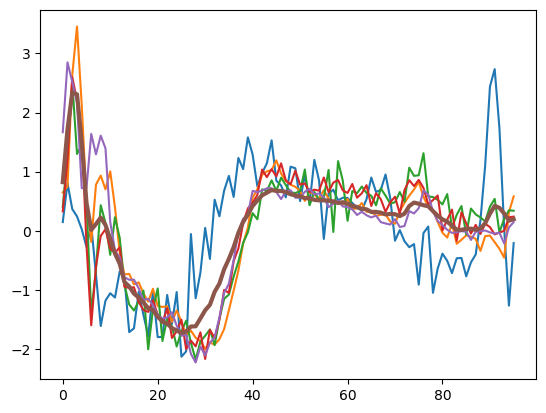

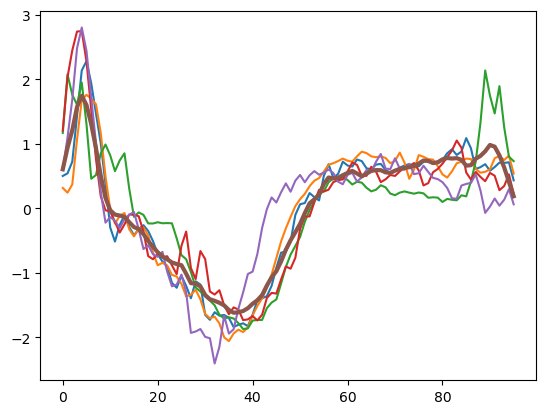

In [100]:
filtered0 = data[labels == 0]
for i in range(5):
    plt.plot(filtered0[i])
plt.plot(km.cluster_centers_[0], linewidth=3)
plt.show()
filtered1 = data[labels == 1]
for i in range(5):
    plt.plot(filtered1[i])
plt.plot(km.cluster_centers_[1], linewidth=3)
plt.show()

## Explanation using shapley values

I have chosen shapley values, which tell us how much of the resulting classification could be attributed to them. `Shap` library is really buggy, so I've used legacy version of the `waterfall` plot.

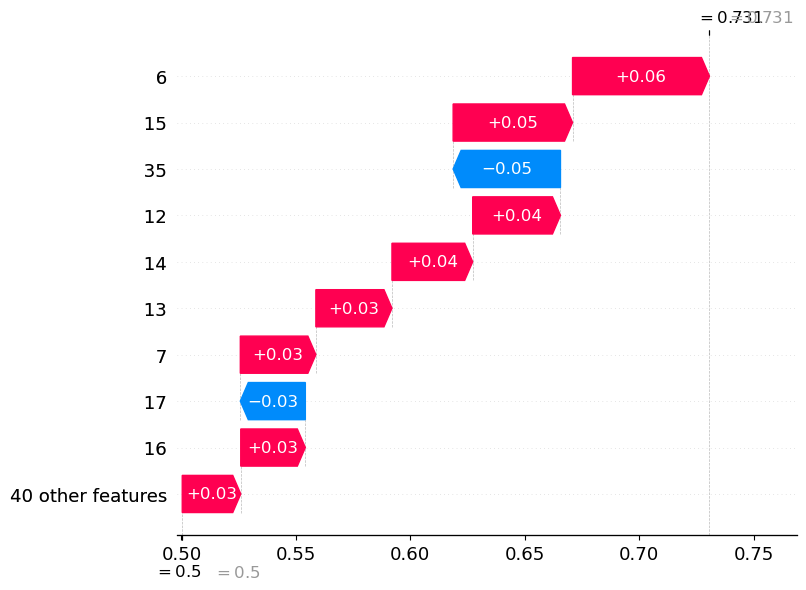

In [101]:
shape = (1,) + df.shape[1:]
explainer = shap.TreeExplainer(clf)
explanation = explainer(df.loc[3])
shap_values = explainer.shap_values(df.loc[3])
expected_value = explainer.expected_value
shap.plots._waterfall.waterfall_legacy(expected_value[0], shap_values[1], features=df.loc[1,:], feature_names=[str(x) for x in df.columns])

and here is the average impact of given feature averaged over the whole dataset

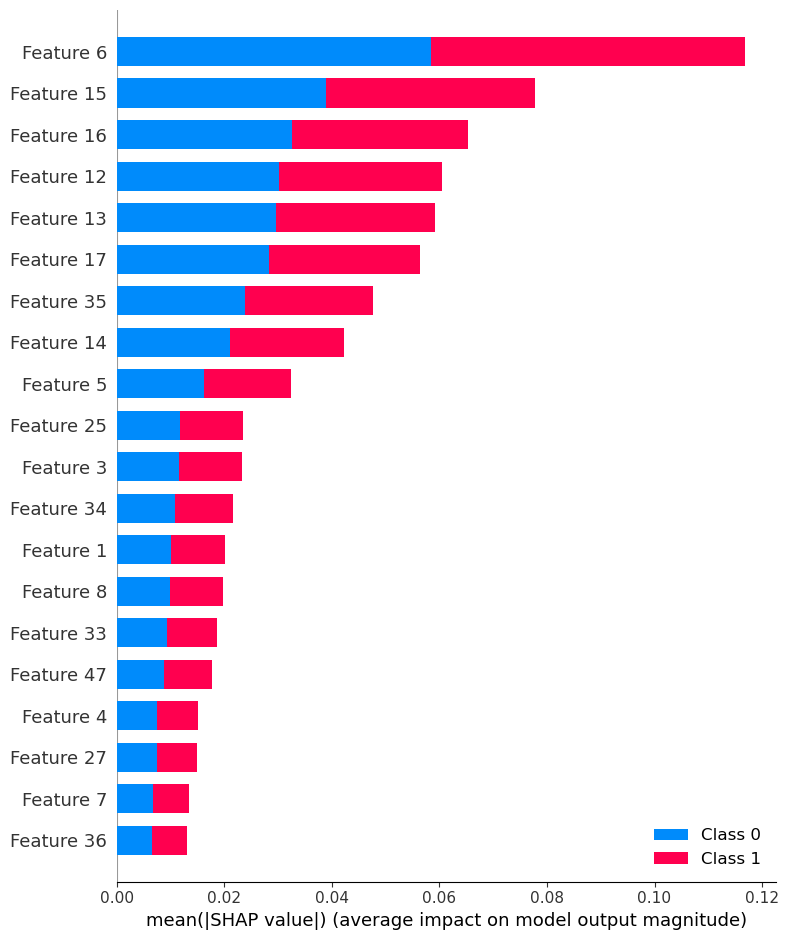

In [102]:
df.columns = [str(x) for x in df.columns]
explainer = shap.TreeExplainer(clf, df)
explanation = explainer.shap_values(df)
shap.summary_plot(explanation)

In [103]:
choosen_x = df.loc[3].to_numpy().reshape(1, -1).astype(np.float32)
display(choosen_x.shape)

clf.predict(choosen_x)

(1, 49)

array([1.])

In [104]:
ce = CounterfactualExplanation(choosen_x, clf.predict)
ce.fit(verbose=True)


0 ennemies found in initial hyperball.
Expanding hypersphere...
Final number of iterations:  2326
Final radius:  (2.334999999999854, 2.3359999999998537)
Final number of ennemies:  1
Feature selection...
Reduced 41 coordinates


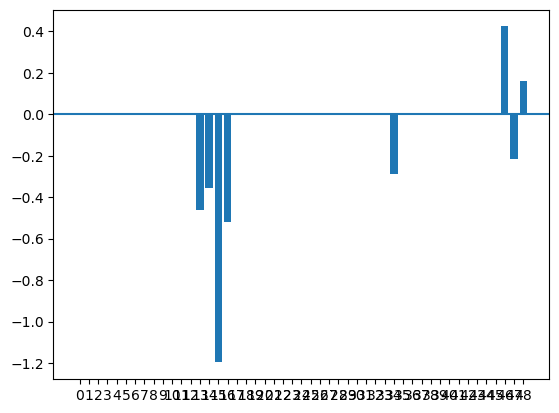

In [105]:
res = ce.enemy - df.loc[3].to_numpy().reshape(1, -1)
plt.bar(df.columns.to_numpy(), res[0])
plt.axhline(y=0)
plt.show()

(49,)

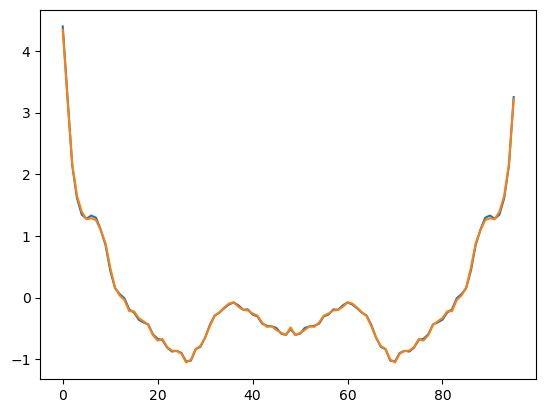

In [122]:
from scipy.fft import irfft

display(choosen_x[0].shape)
plt.plot(irfft(choosen_x[0]), len())
plt.plot(irfft(ce.enemy))
plt.show()

In [ ]:
display(clf.predict(choosen_x))
display(clf.predict(ce.enemy.reshape(1, -1)))

array([1.])

array([-1.])